In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy



In [4]:
# Enter the name of your input file here
inputFile = "seurat.txt"
# Input parameters
nGene = 100
nCell = 3

try:
    os.stat("ComplexityPlots")
except:
    os.mkdir("ComplexityPlots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames

,Sample,DGE filePath,Reads filePath,Soup
0,C1,L:/Duncan/KPSIY/DGEs/C1_20210411_DGE.UMI.txt,L:/Duncan/KPSIY/DGEs/C1_20210411_readsSummary.txt,L:/Duncan/KPSIY/DGEs/M1_20210202_soup.txt
1,C4,L:/Duncan/KPSIY/DGEs/C4_20210411_DGE.UMI.txt,L:/Duncan/KPSIY/DGEs/C4_20210411_readsSummary.txt,L:/Duncan/KPSIY/DGEs/M1_20210202_soup.txt
2,C8,L:/Duncan/KPSIY/DGEs/C8_20210411_DGE.UMI.txt,L:/Duncan/KPSIY/DGEs/C8_20210411_readsSummary.txt,L:/Duncan/KPSIY/DGEs/M1_20210202_soup.txt
3,C7,L:/Duncan/KPSIY/DGEs/C7_20210827_DGE.UMI.txt,L:/Duncan/KPSIY/DGEs/C7_20210827_readsSummary.txt,L:/Duncan/KPSIY/DGEs/M1_20210202_soup.txt
4,P1,L:/Duncan/KP-CBT/DGEs/P1_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P1_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt
5,P2,L:/Duncan/KP-CBT/DGEs/P2_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P2_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt
6,P3,L:/Duncan/KP-CBT/DGEs/P3_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P3_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt
7,P4,L:/Duncan/KP-CBT/DGEs/P4_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P4_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt
8,P5,L:/Duncan/KP-CBT/DGEs/P5_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P5_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt
9,P6,L:/Duncan/KP-CBT/DGEs/P6_20211028_DGE.UMI.txt,L:/Duncan/KP-CBT/DGEs/P6_20211028_readsSummary...,L:/Duncan/KP-CBT/DGEs/S1_20211028_soup.txt


In [5]:
tic = time.time()
first = True
for i in range(0,fileNames.shape[0]):
        
    # read and print sample name
    sampName = str(fileNames.Sample.iloc[i])
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells
        
    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(str(sampName) + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "ComplexityPlots/" + str(sampName) + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()



C1
1353
C4
1589
C8
1850
C7
4999
P1
3150
P2
5566
P3
7618
P4
7975
P5
6914
P6
7841
977.4182801246643


In [6]:
import pyarrow.feather
pyarrow.feather.write_feather(cellsAll, 'cellsAll.feather')  
pyarrow.feather.write_feather(readCountsAll, 'readCountsAll.feather')
np.savetxt('bcs.txt', bcsAll, fmt = "%s")

In [7]:
import sys
sys.path.append('../')
from functions import *

# read in and fix data
cells = pd.read_feather('cellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

filtered out 96 genes that are detected in less than 3 cells
filtered out 20 cells that have less than 100 genes expressed
AnnData object with n_obs × n_vars = 48835 × 17124
    obs: 'orig', 'bc', 'n_genes'
    var: 'n_cells'
normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [7123] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:06)
regressing out n_genes


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig' as categorical
C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bc' as categorical


    finished (0:02:12)
linear scaling
computing PCA
    with n_comps=50
    finished (0:00:08)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:59)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:11)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:49)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:52)


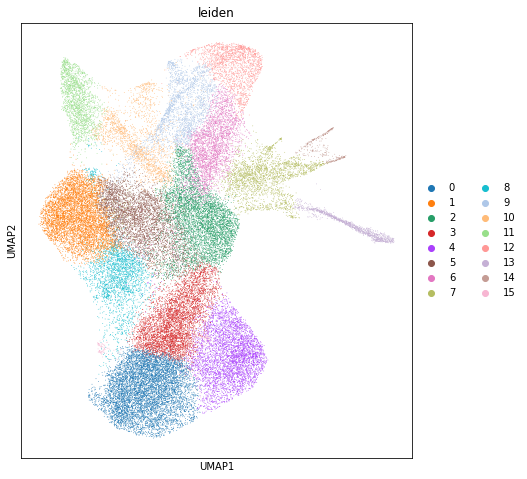

In [8]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('bcs.txt', dtype = str)
adata.obs['orig'] =[x.split('_')[0] for x in adata.obs_names]
adata.obs['bc']= bcs
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = 100)
print(adata)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:46)


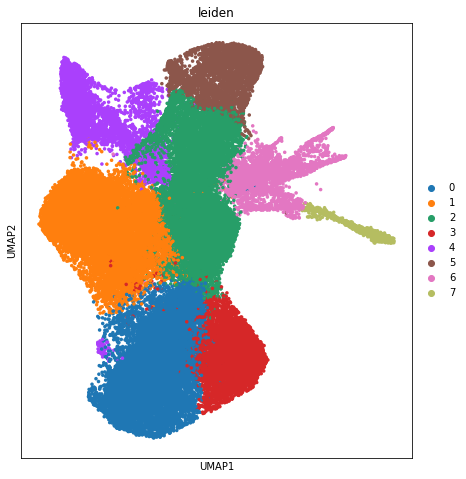

In [9]:
sc.tl.leiden(adata, resolution = .3)
sc.pl.umap(adata, color = 'leiden', size = 50)

In [10]:
getgenes(adata, ['7']).head(10)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
Cd74,3.252557,0.996289,0.131352,0.0,0.0
Cd79b,2.865361,0.975881,0.087505,0.0,0.0
H2-Ab1,2.789654,0.992579,0.112612,0.0,0.0
H2-Aa,2.609121,0.971243,0.066441,0.0,0.0
H2-Eb1,2.543225,0.963822,0.072304,0.0,0.0
Igkc,2.346870,0.933210,0.133740,0.0,0.0
Ms4a1,2.297738,0.866419,0.011768,0.0,0.0
Ighm,2.246976,0.946197,0.278598,0.0,0.0
Cd22,2.200781,0.876623,0.060012,0.0,0.0


In [11]:
getgenes(adata, ['6']).head(10)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
Hbb-bs,3.215728,0.345011,0.036971,3.652625e-162,1.274766e-159
Cst3,2.762518,0.684713,0.237693,0.000000e+00,0.000000e+00
H2-Ab1,2.464453,0.721515,0.095829,0.000000e+00,0.000000e+00
Hbb-bt,2.308250,0.191791,0.015171,1.256281e-90,4.384422e-88
Cd74,2.307705,0.792286,0.111022,0.000000e+00,0.000000e+00
Igkc,2.272019,0.306794,0.141842,5.336358e-82,1.862389e-79
H2-Eb1,2.183534,0.593772,0.061162,0.000000e+00,0.000000e+00
Lyz2,2.128656,0.165605,0.015367,6.458542e-79,2.254031e-76
Mpeg1,2.101522,0.350318,0.013302,3.454518e-222,1.205627e-219


In [13]:
umi_fixed = pd.read_csv('L:/Duncan/KPSIY_all/umi_corrected.csv', index_col = 0)
umi_fixed['correct'] = [x[2:14] for x in umi_fixed.correct]
umi_fixed['id'] = [umi_fixed['sample'].iloc[x] + umi_fixed.correct.iloc[x] for x in range(0, umi_fixed.shape[0])]
adata.obs['id'] = [adata.obs.orig[x] + adata.obs.bc[x] for x in range(0, adata.shape[0])]
adata.obs.head()
umi_fixed.head()

,Barcode,TotalReads,MappedReads,ExonReads,sample,byte,correct,id
0,CGGTGTTGTTCC,1130605,1033330,326803,D4,b'CGGTGTTGTTCC',CGGTGTTGTTCC,D4CGGTGTTGTTCC
1,CGGCTTTAACTT,993269,929311,323116,D4,b'CGGCTTTAACTT',CGGCTTTAACTT,D4CGGCTTTAACTT
2,CCAGCCCACCCC,1161894,996158,265556,D4,b'CCAGCCCACCCC',CCAGCCCACCCC,D4CCAGCCCACCCC
3,GTCACGAGACCG,609973,566456,229955,D4,b'GTCACGAGACCG',GTCACGAGACCG,D4GTCACGAGACCG
4,GCCACCTCTAAC,638947,587817,225844,D4,b'GCCACCTCTAAC',GCCACCTCTAAC,D4GCCACCTCTAAC


In [14]:
adata.obs['id'] = [adata.obs.orig[x] + adata.obs.bc[x] for x in range(0, adata.shape[0])]
adata.obs.head()

,orig,bc,n_genes,n_counts,leiden,id
C1_0,C1,AAAAATTAGAAC,450,648.0,4,C1AAAAATTAGAAC
C1_1,C1,AAAACACCGTAA,441,584.0,5,C1AAAACACCGTAA
C1_2,C1,AAAATTCGTCCT,152,247.0,4,C1AAAATTCGTCCT
C1_4,C1,AAACCGGCAGCG,230,356.0,4,C1AAACCGGCAGCG
C1_5,C1,AAACCTCTAGGT,458,633.0,4,C1AAACCTCTAGGT


In [20]:
keepers = adata.obs_names[adata.obs.id.isin(umi_fixed.id) & ~adata.obs.leiden.isin(['6', '7'])]
print(len(keepers))

41020


In [21]:
adata

AnnData object with n_obs × n_vars = 48835 × 1112
    obs: 'orig', 'bc', 'n_genes', 'n_counts', 'leiden', 'id'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
adata2 = subset(adata, keepers)


In [23]:
metadata = pd.read_csv('L:/Duncan/KPSIY_all/meta.txt', index_col = 0)
adata2.obs['location'] = metadata.Meta1.loc[adata2.obs.orig].values
adata2.obs['tissue'] = metadata.Meta2.loc[adata2.obs.orig].values
adata2.obs['treatment'] = metadata.Meta3.loc[adata2.obs.orig].values

adata2.obs.head()

,orig,bc,n_genes,n_counts,leiden,id,location,tissue,treatment
C1_4,C1,AAACCGGCAGCG,230,356.0,4,C1AAACCGGCAGCG,Flank,Tumor,SIY
C1_6,C1,AAACGGCGCCTT,148,483.0,4,C1AAACGGCGCCTT,Flank,Tumor,SIY
C1_11,C1,AAAGTTTTTATC,234,703.0,2,C1AAAGTTTTTATC,Flank,Tumor,SIY
C1_17,C1,AAATATTAGAAC,4412,22840.0,4,C1AAATATTAGAAC,Flank,Tumor,SIY
C1_31,C1,AACCCTTATAGT,2633,13269.0,4,C1AACCCTTATAGT,Flank,Tumor,SIY


In [26]:
adata.obs.to_csv('allmeta.txt')

In [25]:
import pyarrow.feather
def seuratExport(adata, fname):
    adata.obs.to_csv(fname + '_meta.txt')
    
seuratExport(adata2, 'FlankCBT')